In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
import seaborn as sns
import os
import gc
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [4]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
import shap

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [7]:
df = pd.read_csv("../data/raw/CIC_IoMT_2024_WiFi_MQTT_train.csv")

In [8]:
label_mapping = {
    'Benign': ['Benign_train'],
    
    'Spoofing': ['ARP_Spoofing_train'],

    'Reconnaissance': [
        'Recon-OS_Scan_train',
        'Recon-Ping_Sweep_train',
        'Recon-VulScan_train',
        'Recon-Port_Scan_train'
    ],
    
    'MQTT': [
        'MQTT-Malformed_Data_train',
        'MQTT-DoS-Connect_Flood_train',
        'MQTT-DDoS-Publish_Flood_train',
        'MQTT-DoS-Publish_Flood_train',
        'MQTT-DDoS-Connect_Flood_train'
    ],

    'DoS': [
        'TCP_IP-DoS-TCP1_train', 'TCP_IP-DoS-TCP2_train', 'TCP_IP-DoS-TCP3_train', 'TCP_IP-DoS-TCP4_train',
        'TCP_IP-DoS-UDP1_train', 'TCP_IP-DoS-UDP2_train', 'TCP_IP-DoS-UDP3_train', 'TCP_IP-DoS-UDP4_train',
        'TCP_IP-DoS-ICMP1_train', 'TCP_IP-DoS-ICMP2_train', 'TCP_IP-DoS-ICMP3_train', 'TCP_IP-DoS-ICMP4_train',
        'TCP_IP-DoS-SYN1_train', 'TCP_IP-DoS-SYN2_train', 'TCP_IP-DoS-SYN3_train', 'TCP_IP-DoS-SYN4_train'
    ],

    'DDoS': [
        'TCP_IP-DDoS-TCP1_train', 'TCP_IP-DDoS-TCP2_train', 'TCP_IP-DDoS-TCP3_train', 'TCP_IP-DDoS-TCP4_train',
        'TCP_IP-DDoS-UDP1_train', 'TCP_IP-DDoS-UDP2_train', 'TCP_IP-DDoS-UDP3_train', 'TCP_IP-DDoS-UDP4_train',
        'TCP_IP-DDoS-UDP5_train', 'TCP_IP-DDoS-UDP6_train', 'TCP_IP-DDoS-UDP7_train', 'TCP_IP-DDoS-UDP8_train',
        'TCP_IP-DDoS-ICMP1_train', 'TCP_IP-DDoS-ICMP2_train', 'TCP_IP-DDoS-ICMP3_train', 'TCP_IP-DDoS-ICMP4_train',
        'TCP_IP-DDoS-ICMP5_train', 'TCP_IP-DDoS-ICMP6_train', 'TCP_IP-DDoS-ICMP7_train', 'TCP_IP-DDoS-ICMP8_train',
        'TCP_IP-DDoS-SYN1_train', 'TCP_IP-DDoS-SYN2_train', 'TCP_IP-DDoS-SYN3_train', 'TCP_IP-DDoS-SYN4_train'
    ]
}

In [9]:
def map_category(label):
    for parent, sub_labels in label_mapping.items():
        if label in sub_labels:
            return parent
    return 'Unknown'
df['SuperClass'] = df['label'].apply(map_category)

In [10]:
grouped = df.groupby(['SuperClass', 'label']).size().reset_index(name='Records')
total = len(df)
grouped['Percentage'] = (grouped['Records'] / total) * 100

summary = grouped.groupby('SuperClass')['Records'].sum().reset_index()
summary['Percentage'] = (summary['Records'] / total) * 100

print("Hierarchical Breakdown:")
display(grouped.sort_values(['SuperClass', 'Records'], ascending=[True, False]).head(20))

print("Category Summary:")
display(summary)

Hierarchical Breakdown:


,SuperClass,label,Records,Percentage
0,Benign,Benign_train,192732,2.691475
18,DDoS,TCP_IP-DDoS-UDP2_train,207295,2.894846
19,DDoS,TCP_IP-DDoS-UDP3_train,206604,2.885196
20,DDoS,TCP_IP-DDoS-UDP4_train,206343,2.881551
17,DDoS,TCP_IP-DDoS-UDP1_train,206170,2.879135
21,DDoS,TCP_IP-DDoS-UDP5_train,205507,2.869876
24,DDoS,TCP_IP-DDoS-UDP8_train,204105,2.850298
15,DDoS,TCP_IP-DDoS-TCP3_train,204075,2.849879
10,DDoS,TCP_IP-DDoS-SYN2_train,203669,2.844209
13,DDoS,TCP_IP-DDoS-TCP1_train,202311,2.825245


Category Summary:


,SuperClass,Records,Percentage
0,Benign,192732,2.691475
1,DDoS,4779859,66.750060
2,DoS,1805529,25.213959
3,MQTT,262938,3.671892
4,Reconnaissance,103726,1.448519
5,Spoofing,16047,0.224094


In [11]:
ID_COLS = ['label', 'SuperClass']

In [12]:
DROP_COLS = ['Boot_Time_with_date', 'RTime', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'IMEI']
RATE_COLS = ['Rate', 'Srate', 'Drate'] 
TARGET_COUNTS = {
    'DDoS': 500_000,
    'DoS':  500_000,
    'Benign': 300_000,
    'MQTT': 300_000,
    'Reconnaissance': 200_000,
    'Spoofing': 200_000
}

In [13]:
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
if cols_to_drop:
    print("Dropping ID/time columns:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

In [14]:
df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train,DDoS
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train,DDoS
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train,DDoS
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS


In [15]:
df['SuperClass'].value_counts()

SuperClass
DDoS              4779859
DoS               1805529
MQTT               262938
Benign             192732
Reconnaissance     103726
Spoofing            16047
Name: count, dtype: int64

In [16]:
feature_cols = [c for c in df.columns if c not in ID_COLS]
print(f"Feature count: {len(feature_cols)}")

X_raw = df[feature_cols].copy()
y_raw = df['SuperClass'].copy()

Feature count: 45


In [17]:
non_numeric = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
if non_numeric:
    print("Non-numeric columns detected - converting to numeric (if possible) or dropping:", non_numeric)
    for c in non_numeric:
        X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce')
    non_numeric_after = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
    if non_numeric_after:
        print("Dropping columns still non-numeric:", non_numeric_after)
        X_raw = X_raw.drop(columns=non_numeric_after)

In [18]:
rate_cols_present = [c for c in RATE_COLS if c in X_raw.columns]
if rate_cols_present:
    print("Applying MinMax normalization to rate cols:", rate_cols_present)
    mms = MinMaxScaler()
    X_raw[rate_cols_present] = mms.fit_transform(X_raw[rate_cols_present])

Applying MinMax normalization to rate cols: ['Rate', 'Srate', 'Drate']


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
del X_raw
gc.collect()

0

In [20]:
X_scaled.shape

(7160831, 45)

In [21]:
y_raw.shape

(7160831,)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

In [23]:
import numpy as np
import pandas as pd

def hybrid_balance_safe(df, label_col='SuperClass', target_n=60000, random_state=42):
    np.random.seed(random_state)
    balanced_parts = []
    num_cols = [c for c in df.columns if c not in ['label', label_col]]

    for cls, group in df.groupby(label_col):
        n_avail = len(group)
        print(f"Class {cls} -> available: {n_avail}")

        if n_avail > target_n:
            # Downsample
            sampled = group.sample(n=target_n, random_state=random_state)

        elif n_avail == target_n:
            sampled = group

        elif n_avail >= 5:
            # Gaussian noise augmentation for numeric features
            X = group[num_cols].copy()
            n_to_gen = target_n - n_avail

            # Compute per-column stds and add jitter
            stds = X.std(axis=0, ddof=0).replace(0, 1e-6)
            synth_samples = X.sample(n=n_to_gen, replace=True, random_state=random_state)
            noise = np.random.normal(0, 0.01, synth_samples.shape) * stds.values
            synth_samples = synth_samples + noise

            synth_df = synth_samples.copy()
            synth_df[label_col] = cls
            synth_df['label'] = group['label'].sample(
                n=n_to_gen, replace=True, random_state=random_state
            ).values

            sampled = pd.concat([group, synth_df], ignore_index=True)

        else:
            # Tiny class — replicate with replacement
            sampled = group.sample(n=target_n, replace=True, random_state=random_state)

        balanced_parts.append(sampled)

    balanced_df = (
        pd.concat(balanced_parts)
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )

    print("\n✅ Done! New distribution:")
    print(balanced_df[label_col].value_counts())
    return balanced_df

In [24]:
subset_df = hybrid_balance_safe(df, label_col='SuperClass', target_n=60000)

Class Benign -> available: 192732
Class DDoS -> available: 4779859
Class DoS -> available: 1805529
Class MQTT -> available: 262938
Class Reconnaissance -> available: 103726
Class Spoofing -> available: 16047

✅ Done! New distribution:
SuperClass
DDoS              60000
Reconnaissance    60000
Spoofing          60000
DoS               60000
Benign            60000
MQTT              60000
Name: count, dtype: int64


In [25]:
subset_df.duplicated().sum()

np.int64(28052)

In [26]:
X = subset_df.drop(columns=['label','SuperClass'], errors='ignore')
y = subset_df['SuperClass']

In [27]:
# Combine features and labels
df_combined = pd.concat([X, y], axis=1)

df_combined = df_combined.drop_duplicates()

X_subset = df_combined.drop("SuperClass", axis=1)
y_subset = df_combined["SuperClass"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, stratify=y_subset, test_size=0.2, random_state=42
)

In [28]:
print(X_train.duplicated().sum(), X_test.duplicated().sum())

0 0


In [29]:
X_train.shape

(265513, 45)

In [30]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

In [31]:
X_train_scaledd = scaler.fit_transform(X_train)
X_test_scaledd = scaler.transform(X_test)

In [32]:
X_train_scaled = X_train_scaledd[..., np.newaxis]
X_test_scaled = X_test_scaledd[..., np.newaxis]

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
if X_train_t.dim() == 4:
    X_train_t = X_train_t.squeeze(-1)
elif X_train_t.dim() == 2:
    X_train_t = X_train_t.unsqueeze(-1)

y_train_t = torch.tensor(y_train_enc, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
if X_test_t.dim() == 4:
    X_test_t = X_test_t.squeeze(-1)
elif X_test_t.dim() == 2:
    X_test_t = X_test_t.unsqueeze(-1)

y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

In [34]:
from torch.utils.data import random_split, DataLoader, TensorDataset

In [35]:
num_clients = 3

In [36]:
dataset = TensorDataset(X_train_t, y_train_t)
data_per_client = len(dataset) // num_clients

lengths = [data_per_client] * (num_clients - 1)
lengths.append(len(dataset) - sum(lengths))

In [37]:
client_datasets = random_split(dataset, lengths)

In [38]:
client_loaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in client_datasets]

In [39]:
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

feature_names = [f"feature_{i}" for i in range(X_train_flat.shape[1])]
class_names = [str(c) for c in range(num_classes)]

lime_explainer = LimeTabularExplainer(
    X_train_flat, 
    feature_names=X.columns.tolist(),   # 👈 Add this line
    class_names=class_names,            # optional, if you have them
    discretize_continuous=True
)

In [40]:
def client_update(model, optimizer, criterion, train_loader, device, epochs=1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for _ in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total
    acc = correct / total
    return model.state_dict(), avg_loss, acc

In [41]:
def federated_average(state_dicts):
    avg_dict = {}
    for key in state_dicts[0].keys():
        avg_dict[key] = torch.stack([sd[key].float() for sd in state_dicts], 0).mean(0)
    return avg_dict

In [42]:
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [43]:
input_features = 1              # last dim from (seq_len, features)
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [44]:
import torch.nn.functional as F
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


# -------------------------------
# Residual Conv1D Block
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same")
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


# -------------------------------
# Advanced Residual + BiLSTM + Attention Model
# -------------------------------
class RCLNet_Attn_Pro(nn.Module):
    def __init__(self, input_features, num_classes, max_len=None):
        super(RCLNet_Attn_Pro, self).__init__()
        self.use_pos_enc = max_len is not None
        if self.use_pos_enc:
            self.pos_enc = PositionalEncoding(d_model=input_features, max_len=max_len)

        # CNN residual encoder
        self.res1 = ResidualBlock(1, 64)
        self.res2 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool1d(2)

        # BiLSTM + MultiHeadAttention
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, dropout=0.2, batch_first=True)
        self.norm = nn.LayerNorm(128)

        # Dense classifier
        self.fc1 = nn.Linear(128, 256)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Input: (batch, seq_len, features)
        if self.use_pos_enc:
            x = self.pos_enc(x)

        # CNN expects (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (B, T, F)

        # BiLSTM + MultiHeadAttention
        x, _ = self.lstm(x)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm(x + attn_out)

        # Global average pooling (mean over sequence)
        x = x.mean(dim=1)

        # Dense classifier
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [45]:
model = RCLNet_Attn_Pro(input_features, num_classes, max_len=seq_len).to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

0.296006 M parameters


In [46]:
from lime import lime_tabular
import shap
import numpy as np

# Prediction function usable by both LIME and SHAP
def predict_fn(model, X):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [47]:
from collections import defaultdict

client_lime_summaries = defaultdict(list)  

In [48]:
from lime.lime_tabular import LimeTabularExplainer
from collections import defaultdict, Counter
import numpy as np

# Flatten X for LIME (your model takes 45x1 but LIME needs 2D)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
feature_names = [f"feature_{i}" for i in range(X_train_flat.shape[1])]
class_names = [str(c) for c in range(num_classes)]

lime_explainer = LimeTabularExplainer(
    X_train_flat,
    feature_names=X.columns.tolist(),
    class_names=class_names,
    discretize_continuous=True
)

client_lime_summaries = defaultdict(list)

In [49]:
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
global_model = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss()
global_epochs = 10
local_epochs = 2

for round in tqdm(range(global_epochs), desc="🌍 Global Rounds"):
    local_state_dicts = []
    client_metrics = []

    print(f"\n🌐 Global Round {round+1}/{global_epochs}")

    for client_id, loader in tqdm(enumerate(client_loaders), total=len(client_loaders), desc="🤝 Client Updates", leave=False):
        local_model = copy.deepcopy(global_model)
        optimizer = torch.optim.Adam(local_model.parameters(), lr=1e-3)

        local_state, local_loss, local_acc = client_update(
            local_model, optimizer, criterion, loader, device, epochs=local_epochs
        )

        local_state_dicts.append(local_state)
        client_metrics.append((local_loss, local_acc))
        print(f"  🧩 Client {client_id+1} | Loss: {local_loss:.4f} | Acc: {local_acc:.4f}")

        # ===== LIME CLIENT-SIDE EXPLANATION =====
        sample_batch, _ = next(iter(loader))
        sample_batch = sample_batch[:1].to(device)   # one sample, keeps compute small
        sample_flat = sample_batch.cpu().numpy().reshape(1, -1)

        def lime_predict(x):
            x_t = torch.tensor(x, dtype=torch.float32).reshape(len(x), -1, 1).to(device)
            with torch.no_grad():
                logits = local_model(x_t)
                return torch.softmax(logits, dim=1).cpu().numpy()

        exp = lime_explainer.explain_instance(
            sample_flat[0],
            lime_predict,
            num_features=8
        )

        for feat, score in exp.as_list():
            client_lime_summaries[client_id].append((feat, score))
        # ========================================

    # FedAvg
    avg_state = federated_average(local_state_dicts)
    global_model.load_state_dict(avg_state)

    # Evaluate global model
    global_model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = global_model(X_test)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_test).sum().item()
            total += y_test.size(0)

    global_acc = correct / total
    print(f"🏁 Global Model Accuracy after Round {round+1}: {global_acc:.4f}")


🌍 Global Rounds:   0%|          | 0/10 [00:00<?, ?it/s]


🌐 Global Round 1/10


  🧩 Client 1 | Loss: 0.3450 | Acc: 0.8200


  🧩 Client 2 | Loss: 0.3415 | Acc: 0.8251


  🧩 Client 3 | Loss: 0.3470 | Acc: 0.8215


🌍 Global Rounds:  10%|█         | 1/10 [01:20<12:08, 80.94s/it]

🏁 Global Model Accuracy after Round 1: 0.6119

🌐 Global Round 2/10


  🧩 Client 1 | Loss: 0.3060 | Acc: 0.8451


  🧩 Client 2 | Loss: 0.3036 | Acc: 0.8459


  🧩 Client 3 | Loss: 0.3033 | Acc: 0.8464


🌍 Global Rounds:  20%|██        | 2/10 [02:33<10:06, 75.84s/it]

🏁 Global Model Accuracy after Round 2: 0.8575

🌐 Global Round 3/10


  🧩 Client 1 | Loss: 0.2847 | Acc: 0.8575


  🧩 Client 2 | Loss: 0.2847 | Acc: 0.8566


  🧩 Client 3 | Loss: 0.2840 | Acc: 0.8563


🌍 Global Rounds:  30%|███       | 3/10 [03:42<08:29, 72.76s/it]

🏁 Global Model Accuracy after Round 3: 0.8628

🌐 Global Round 4/10


  🧩 Client 1 | Loss: 0.2757 | Acc: 0.8620


  🧩 Client 2 | Loss: 0.2744 | Acc: 0.8619


  🧩 Client 3 | Loss: 0.2735 | Acc: 0.8632


🌍 Global Rounds:  40%|████      | 4/10 [04:51<07:07, 71.21s/it]

🏁 Global Model Accuracy after Round 4: 0.8664

🌐 Global Round 5/10


  🧩 Client 1 | Loss: 0.2693 | Acc: 0.8651


  🧩 Client 2 | Loss: 0.2681 | Acc: 0.8644


  🧩 Client 3 | Loss: 0.2667 | Acc: 0.8657


🌍 Global Rounds:  50%|█████     | 5/10 [06:00<05:52, 70.51s/it]

🏁 Global Model Accuracy after Round 5: 0.8691

🌐 Global Round 6/10


  🧩 Client 1 | Loss: 0.2643 | Acc: 0.8667


  🧩 Client 2 | Loss: 0.2642 | Acc: 0.8661


  🧩 Client 3 | Loss: 0.2620 | Acc: 0.8684


🌍 Global Rounds:  60%|██████    | 6/10 [07:10<04:40, 70.20s/it]

🏁 Global Model Accuracy after Round 6: 0.8733

🌐 Global Round 7/10


  🧩 Client 1 | Loss: 0.2608 | Acc: 0.8690


  🧩 Client 2 | Loss: 0.2599 | Acc: 0.8680


  🧩 Client 3 | Loss: 0.2579 | Acc: 0.8706


🌍 Global Rounds:  70%|███████   | 7/10 [08:18<03:28, 69.54s/it]

🏁 Global Model Accuracy after Round 7: 0.8753

🌐 Global Round 8/10


  🧩 Client 1 | Loss: 0.2572 | Acc: 0.8709


  🧩 Client 2 | Loss: 0.2571 | Acc: 0.8698


  🧩 Client 3 | Loss: 0.2551 | Acc: 0.8714


🌍 Global Rounds:  80%|████████  | 8/10 [09:24<02:17, 68.61s/it]

🏁 Global Model Accuracy after Round 8: 0.8750

🌐 Global Round 9/10


  🧩 Client 1 | Loss: 0.2553 | Acc: 0.8714


  🧩 Client 2 | Loss: 0.2546 | Acc: 0.8708


  🧩 Client 3 | Loss: 0.2524 | Acc: 0.8734


🌍 Global Rounds:  90%|█████████ | 9/10 [10:32<01:08, 68.35s/it]

🏁 Global Model Accuracy after Round 9: 0.8762

🌐 Global Round 10/10


  🧩 Client 1 | Loss: 0.2532 | Acc: 0.8721


  🧩 Client 2 | Loss: 0.2525 | Acc: 0.8719


  🧩 Client 3 | Loss: 0.2509 | Acc: 0.8734


🌍 Global Rounds: 100%|██████████| 10/10 [11:44<00:00, 70.45s/it]

🏁 Global Model Accuracy after Round 10: 0.8744


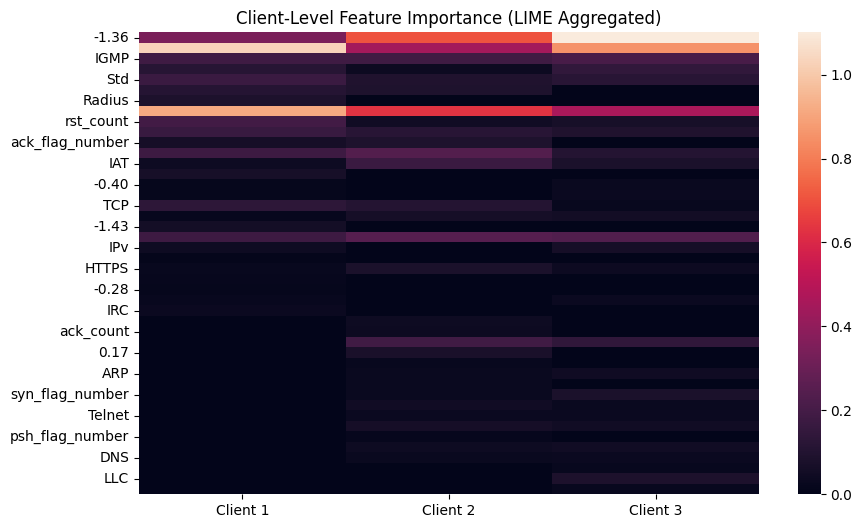

In [50]:
def aggregate_client_lime_summaries(client_lime_summaries):
    client_feature_scores = {}
    for client, pairs in client_lime_summaries.items():
        counter = Counter()
        for feat, score in pairs:
            feat_name = feat.split(" ")[0]
            counter[feat_name] += abs(score)
        client_feature_scores[f"Client {client+1}"] = counter
    
    df = pd.DataFrame(client_feature_scores).fillna(0)

    plt.figure(figsize=(10,6))
    sns.heatmap(df, annot=False)
    plt.title("Client-Level Feature Importance (LIME Aggregated)")
    plt.show()

aggregate_client_lime_summaries(client_lime_summaries)

In [51]:
def compare_client_explanations(client_lime_summaries):
    aggregate_client_lime_summaries(client_lime_summaries)
    print("\nInterpretation:")
    print("If heatmap rows vary strongly = feature importance differs per client (data drift).")
    print("If heatmap rows look similar = global model consistency across clients.")

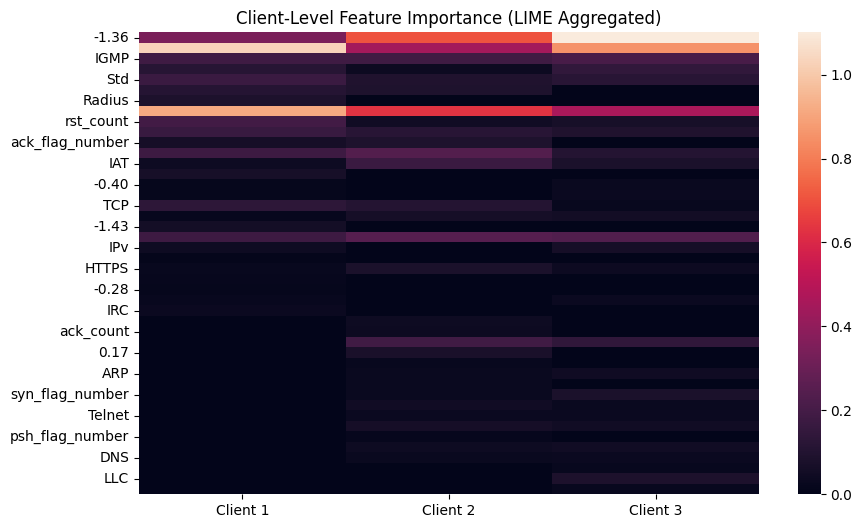


Interpretation:
If heatmap rows vary strongly = feature importance differs per client (data drift).
If heatmap rows look similar = global model consistency across clients.


In [52]:
compare_client_explanations(client_lime_summaries)

In [53]:
def remove_inplace(model):
    for module in model.modules():
        if hasattr(module, 'inplace') and module.inplace:
            module.inplace = False

remove_inplace(global_model)
global_model = global_model.to(device)

In [54]:
import shap
import torch
import numpy as np

# Convert test + background to 2D (samples, features)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat  = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# Background sample (small)
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 40, replace=False)]

# Wrapper model -> returns probabilities
def model_predict(x_numpy):
    x_t = torch.tensor(x_numpy, dtype=torch.float32).reshape(len(x_numpy), -1, 1).to(device)
    with torch.no_grad():
        logits = global_model(x_t)
        return torch.softmax(logits, dim=1).cpu().numpy()

# KernelExplainer (NO MODEL CHANGE NEEDED)
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values (small subset for speed)
shap_values = explainer.shap_values(X_test_flat[:80], nsamples=120)

100%|██████████| 80/80 [00:06<00:00, 12.93it/s]


In [55]:
feature_names = X.columns.tolist()

In [56]:
seq_len = 6
X_seq = X.values.reshape(-1, seq_len, 1)

In [57]:
shap_values_class0 = shap_values[0]       # (samples, 6)
test_data_fixed = test_data[:shap_values_class0.shape[0]]  # match sample count

feature_names = [f"Feature_{i}" for i in range(shap_values_class0.shape[1])]

shap.summary_plot(shap_values_class0,
                  test_data_fixed,
                  feature_names=feature_names,
                  max_display=6)

NameError: name 'test_data' is not defined

In [ ]:
feature_names

['Header_Length',
 'Protocol Type',
 'Duration',
 'Rate',
 'Srate',
 'Drate',
 'fin_flag_number',
 'syn_flag_number',
 'rst_flag_number',
 'psh_flag_number',
 'ack_flag_number',
 'ece_flag_number',
 'cwr_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'rst_count',
 'HTTP',
 'HTTPS',
 'DNS',
 'Telnet',
 'SMTP',
 'SSH',
 'IRC',
 'TCP',
 'UDP',
 'DHCP',
 'ARP',
 'ICMP',
 'IGMP',
 'IPv',
 'LLC',
 'Tot sum',
 'Min',
 'Max',
 'AVG',
 'Std',
 'Tot size',
 'IAT',
 'Number',
 'Magnitue',
 'Radius',
 'Covariance',
 'Variance',
 'Weight']

In [ ]:
shap.summary_plot(shap_values_class0,
                  X_plot,
                  feature_names=feature_names,
                  plot_type="bar",
                  max_display=45

In [ ]:
for i, sv in enumerate(shap_values):
    print(i, sv.shape)

0 (45, 6)
1 (45, 6)
2 (45, 6)
3 (45, 6)
4 (45, 6)
5 (45, 6)
6 (45, 6)
7 (45, 6)
8 (45, 6)
9 (45, 6)
10 (45, 6)
11 (45, 6)
12 (45, 6)
13 (45, 6)
14 (45, 6)
15 (45, 6)
16 (45, 6)
17 (45, 6)
18 (45, 6)
19 (45, 6)
20 (45, 6)
21 (45, 6)
22 (45, 6)
23 (45, 6)
24 (45, 6)
25 (45, 6)
26 (45, 6)
27 (45, 6)
28 (45, 6)
29 (45, 6)
30 (45, 6)
31 (45, 6)
32 (45, 6)
33 (45, 6)
34 (45, 6)
35 (45, 6)
36 (45, 6)
37 (45, 6)
38 (45, 6)
39 (45, 6)
40 (45, 6)
41 (45, 6)
42 (45, 6)
43 (45, 6)
44 (45, 6)
45 (45, 6)
46 (45, 6)
47 (45, 6)
48 (45, 6)
49 (45, 6)
50 (45, 6)
51 (45, 6)
52 (45, 6)
53 (45, 6)
54 (45, 6)
55 (45, 6)
56 (45, 6)
57 (45, 6)
58 (45, 6)
59 (45, 6)
60 (45, 6)
61 (45, 6)
62 (45, 6)
63 (45, 6)


In [ ]:
shap_class = shap_values[1]

In [ ]:
shap_exp = shap.Explanation(
    values=shap_class,
    base_values=explainer.expected_value[1],
    data=ref_batch.cpu().numpy().reshape(len(ref_batch), -1),
    feature_names=X.columns.tolist()
)

In [ ]:
X.columns.tolist()

['Header_Length',
 'Protocol Type',
 'Duration',
 'Rate',
 'Srate',
 'Drate',
 'fin_flag_number',
 'syn_flag_number',
 'rst_flag_number',
 'psh_flag_number',
 'ack_flag_number',
 'ece_flag_number',
 'cwr_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'rst_count',
 'HTTP',
 'HTTPS',
 'DNS',
 'Telnet',
 'SMTP',
 'SSH',
 'IRC',
 'TCP',
 'UDP',
 'DHCP',
 'ARP',
 'ICMP',
 'IGMP',
 'IPv',
 'LLC',
 'Tot sum',
 'Min',
 'Max',
 'AVG',
 'Std',
 'Tot size',
 'IAT',
 'Number',
 'Magnitue',
 'Radius',
 'Covariance',
 'Variance',
 'Weight']

In [ ]:
# import shap
# from lime.lime_tabular import LimeTabularExplainer
# import numpy as np

In [ ]:
# sample_X = X_test_t[:200].to(device)
# sample_y = y_test_t[:200]

In [ ]:
# global_model.eval()

In [ ]:
# def model_predict(x):
#     x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
#     with torch.no_grad():
#         out = global_model(x_t)
#         probs = torch.nn.functional.softmax(out, dim=1)
#     return probs.cpu().numpy()

In [ ]:


# # flatten only for LIME
# X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
# X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# feature_names = [f"feature_{i}" for i in range(X_train_flat.shape[1])]
# class_names = [str(c) for c in range(num_classes)]

# lime_explainer = LimeTabularExplainer(
#     X_train_flat, 
#     feature_names=X.columns.tolist(),   # 👈 Add this line
#     class_names=class_names,            # optional, if you have them
#     discretize_continuous=True
# )

# # wrapper to make LIME work with your 3D model
# def lime_predict(x):
#     x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)  # (B, 45, 1)
#     with torch.no_grad():
#         outputs = model(x_t)
#         probs = torch.softmax(outputs, dim=1)
#     return probs.cpu().numpy()

# # explain one random instance
# idx = np.random.randint(0, len(X_test_flat))
# exp = lime_explainer.explain_instance(
#     X_test_flat[idx],
#     lime_predict,
#     num_features=10
# )

# print(exp.as_list())

In [ ]:
# from IPython.display import display, HTML

# html = exp.as_html()
# display(HTML(html))

In [ ]:
# num_samples_to_explain = 10  # you can increase this
# sample_indices = np.random.choice(len(X_test_flat), num_samples_to_explain, replace=False)

# explanations = []
# for idx in sample_indices:
#     exp = lime_explainer.explain_instance(
#         X_test_flat[idx],
#         lime_predict,
#         num_features=10
#     )
#     explanations.append(exp)
#     print(f"\nInstance {idx} explanation:")
#     print(exp.as_list())

In [ ]:
# from collections import Counter
# import pandas as pd

# feature_importances = Counter()

# for exp in explanations:
#     for feature, weight in exp.as_list():
#         feature_importances[feature] += abs(weight)

# lime_global_importance = pd.DataFrame(
#     feature_importances.most_common(),
#     columns=['Feature', 'Aggregate_Importance']
# )

# print(lime_global_importance.head(10))


In [ ]:
# plt.figure(figsize=(10, 5))
# plt.barh(lime_global_importance['Feature'], lime_global_importance['Aggregate_Importance'])
# plt.xlabel("Aggregate Importance")
# plt.title("Global Feature Importance (LIME)")
# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
# masker = shap.maskers.Independent(X_train_t[:300].cpu().numpy())

# # ✅ create explainer with correct arguments
# explainer = shap.Explainer(model_predict, masker)

# # compute SHAP values for sample batch
# shap_values = explainer(sample_X.cpu().numpy())

# # visualize feature importance
# shap.summary_plot(shap_values, sample_X.cpu().numpy(), show=False)
# plt.title("SHAP Summary for Global Federated Model")
# plt.show()